In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
import tensorflow_probability as tfp

from statsmodels.tsa.seasonal import seasonal_decompose

import os

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.12.0
0.20.1


In [3]:
DATA_FOLDER = r'D:\project\BA\final\data'

In [32]:
#build class BSTS with those function : innit, load data, decompose , fit, predict_test, predict_future, plot
class BSTS:
    def __init__(self,data_path) -> None:
        self.data_path = data_path
        self.test_size = 0
        self.train_size = 0
        self.val_size = 0
        self.test_valid_size = 0
        self.df = None
        self.test_data = None
        self.train_data = None
        self.val_data = None
        self.p_value = 0
        self.d_value = 0
        self.q_value = 0
        self.step_forecast = 0
        
        return None
    
    def split_size(self, test_size, val_size):
        self.test_size = test_size 
        self.train_size = 1 - test_size -val_size
        self.val_size = val_size

        self.test_valid_size = test_size  + val_size
        return None
    
    def split_data(self,test_size, val_size):
        self.df = self.load_data()
        self.split_size(float(test_size), float(val_size))
        test_start_date = self.df.index[int(self.train_size * len(self.df))]
        test_start_pos = self.df.index.get_loc(test_start_date)
        # self.test_data = self.df.iloc[int(self.train_size*len(self.df)):]
        self.test_val_data = self.df.iloc[test_start_pos:]

         #get val_data from test_val_data
        val_start_date = self.df.index[int(self.train_size * len(self.df)) + int(self.test_size * len(self.df))]

        val_start_pos = self.df.index.get_loc(val_start_date)
     
        self.val_data = self.df.iloc[val_start_pos:]
        #get test_data from test_val_data
        self.test_data = self.df.iloc[test_start_pos:val_start_pos]

        train_end_date = self.df.index[int(self.train_size * len(self.df)) - 1]
        train_end_pos = self.df.index.get_loc(train_end_date)

        # self.train_data = self.df.iloc[:int(self.train_size*len(self.df))]
        self.train_data = self.df.iloc[:train_end_pos + 1]
        self.step_forecast = len(self.test_val_data) + 30
        return None

    def info_data(self):
        #print len of train,test,val 
        print('Dataset size', len(self.df),'\n')
        print('Train size : ',len(self.train_data))
        print('Test size : ',len(self.test_data))
        print('Valid size : ',len(self.val_data))
        return None

    def load_data(self):
        df = pd.read_csv(self.data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        # df['Close'] = df['Close'].str.replace(',', '')
        # df['Close'] = df['Close'].astype(float)
        df['Close'] = df['Close'].astype(np.float32)

        df.set_index('Date', inplace=True)
        df.sort_index(axis=0, ascending=True, inplace=True)
        return df
    
    # def sesonal_decompose(self):
    #     data = self.df
    #     data = data[self.train_size:]
    #     result = seasonal_decompose(data['Close'],model='multiplicative',period=90)
    #     fig = result.plot()
    #     fig.set_size_inches(16,12)
    #     plt.show()
    #     return None
    
    def local_level_model(self):
        train_data = self.train_data
        _train = tfp.sts.regularize_series(train_data['Close'])
        level = tfp.sts.LocalLevel(
        observed_time_series=_train,
        name='local_level')
        return level
    
    def local_linear_trend_model(self):
        train_data = self.train_data
        _train = tfp.sts.regularize_series(train_data['Close'])
        trend = tfp.sts.LocalLinearTrend(
        observed_time_series=_train,
        name='local_trend')
        return trend
    

    def seasonal_state_model(self):
        train_data = self.train_data
        _train = tfp.sts.regularize_series(train_data['Close'])
        seasonal = tfp.sts.Seasonal(
        num_seasons=3,
        observed_time_series=_train,
        name='seasonal')
        return seasonal
    
    def semi_local_linear_trend_model(self):
        train_data = self.train_data
        _train = tfp.sts.regularize_series(train_data['Close'])
        trend = tfp.sts.SemiLocalLinearTrend(
        observed_time_series=_train,
        name='semi_local')
        return trend
    
    def sum_model(self, list_model_string):
        dic_model ={'local_level':self.local_level_model(),'local_linear_trend':self.local_linear_trend_model(),
                    'seasonal':self.seasonal_state_model(),'semi_local_linear_trend':self.semi_local_linear_trend_model()}
        map_list_model = [dic_model[model_name] for model_name in list_model_string]
        model_sum = tfp.sts.Sum(map_list_model)
        return model_sum
    
    def fit_surrogate_posterior(self,model):
        data = self.train_data
        train_data = tfp.sts.regularize_series(data['Close'])
        

        # Fit model
        # num_variational_steps = 500
        num_optimizer_steps = 5000
        
        surrogate_posterior = tfp.sts.build_factored_surrogate_posterior(model=model)
        optimizer = tf.optimizers.Adam(learning_rate=0.1)

        # # Add L2 regularization to the target log probability function
        # regularizer = tf.keras.regularizers.L2(0.01)
        # target_log_prob_fn = model.joint_log_prob(observed_time_series=train_data)
        # target_log_prob_fn = lambda **kwargs: target_log_prob_fn(**kwargs) - regularizer(model.trainable_variables)
        
        @tf.function(experimental_compile=True)
        def train():
            elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
                target_log_prob_fn=model.joint_log_prob(observed_time_series=train_data),
                surrogate_posterior=surrogate_posterior,
                optimizer=optimizer,
                num_steps=num_optimizer_steps)
            return tf.cast(elbo_loss_curve, dtype=tf.float32)

        elbo_loss_curve = train()
        # Generate forecasts
        forecast_dist = tfp.sts.forecast(
            model,
            observed_time_series=train_data,
            parameter_samples=surrogate_posterior.sample(50),
            num_steps_forecast= self.step_forecast)

        forecast_mean, forecast_scale, forecast_samples = (
            forecast_dist.mean().numpy()[..., 0],
            forecast_dist.stddev().numpy()[..., 0],
            forecast_dist.sample(500).numpy()[..., 0])
        

        
        return forecast_samples
    
    def calc_mape(self,y_true,y_pred):
        # get mape error
        mape = np.mean(np.abs((y_true - y_pred)/y_true)*100)
        return mape
    def calc_mda(self,y_true,y_pred):
        y_true_diff = np.diff(y_true)
        y_pred_diff = np.diff(y_pred)
        correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
        return np.mean(correct_direction) * 100

    def calc_rmse(self,y_true,y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = sqrt(mse)
        return rmse
    
    def prediction(self, forecast_samples):
        
        
        val_pred = forecast_samples[:,len(self.test_data):forecast_samples.shape[1]-30]
        test_pred = forecast_samples[:,:len(self.test_data)]
        future_predict = forecast_samples[:,forecast_samples.shape[1]-30:]

        print('forecast_samples size : ',forecast_samples.shape[1])
        print('TestPred size : ',test_pred.shape[1])
        print('ValidPred size : ',val_pred.shape[1])

        return test_pred,val_pred,future_predict


    def report_mape_rmse_mda(self, forecast_samples):
        #use usual auto arima not apply window slide
        test_pred,val_pred,future_predict = self.prediction(forecast_samples)
        test_pred = np.median(test_pred, axis = 0)
        val_pred = np.median(val_pred, axis = 0)
        future_predict = np.median(future_predict, axis = 0)

        valid_rmse = self.calc_rmse(val_pred, self.val_data['Close'])
        test_rmse = self.calc_rmse(test_pred, self.test_data['Close'])

        valid_mape = self.calc_mape(val_pred, self.val_data['Close'].values)
        test_mape = self.calc_mape(test_pred, self.test_data['Close'].values)

        valid_mda = self.calc_mda(val_pred, self.val_data['Close'])
        test_mda = self.calc_mda(test_pred, self.test_data['Close'])

        # In kết quả
        print('Validation RMSE:', valid_rmse)
        print('Testing RMSE:', test_rmse)
        print('Validation MAPE:', valid_mape)
        print('Testing MAPE:', test_mape)
        print('Validation MDA:', valid_mda)
        print('Testing MDA:', test_mda)

        return test_pred,val_pred, future_predict
    def report_mape_rmse_mda_min(self, best_sample):
        #use usual auto arima not apply window slide
        test_pred = best_sample[:len(self.test_data)]
        val_pred = best_sample[len(self.test_data):len(self.test_data)+len(self.val_data)]
        future_predict = best_sample[len(self.test_data)+len(self.val_data):]

        valid_rmse = self.calc_rmse(val_pred, self.val_data['Close'])
        test_rmse = self.calc_rmse(test_pred, self.test_data['Close'])

        valid_mape = self.calc_mape(val_pred, self.val_data['Close'].values)
        test_mape = self.calc_mape(test_pred, self.test_data['Close'].values)

        valid_mda = self.calc_mda(val_pred, self.val_data['Close'])
        test_mda = self.calc_mda(test_pred, self.test_data['Close'])

        # In kết quả
        print('Validation RMSE:', valid_rmse)
        print('Testing RMSE:', test_rmse)
        print('Validation MAPE:', valid_mape)
        print('Testing MAPE:', test_mape)
        print('Validation MDA:', valid_mda)
        print('Testing MDA:', test_mda)

        return None
    #wirte fuction get forecast_samples from model, calc mape, rmse, mda, find forecast_sample that have min average sum(mape, rmse, mda) between forecast_samples -30 and test_val_data
    def find_best_forecast_sample(self,forecast_samples):
        test_pred,val_pred,future_predict = self.prediction(forecast_samples)
        forecast_test_valid = np.concatenate((val_pred,test_pred),axis=1)
        idx_min = 0 
        min_sum = 0
       

        for idx, item in enumerate(forecast_test_valid) : 
            mape = self.calc_mape(item, self.test_val_data['Close'].values)
            rmse = self.calc_rmse(item, self.test_val_data['Close'])
            mda = self.calc_mda(item, self.test_val_data['Close'])
            sum_mape_rmse_mda = mape + rmse + mda
            if idx == 0:
                min_sum = sum_mape_rmse_mda
            if sum_mape_rmse_mda < min_sum:
                min_sum = sum_mape_rmse_mda
               
                idx_min = idx
        sample_min = forecast_samples[idx_min]
        return sample_min
    def plot_best_sample(self, best_sample,title):
        #plot test prediction and future prediction
        print('Evaluate ----------------- ')
        self.report_mape_rmse_mda_min(best_sample)
        # fig, ax = plt.subplots(figsize=(16, 12))
        fig, ax = plt.subplots(figsize=(10,8))
        data_actual =  self.df
        future_predict_index = pd.date_range(start=self.test_val_data.index[-1], periods=30, freq=self.test_data.index.freq)
        
        ax.plot(data_actual.index, data_actual['Close'], label='Train',color='blue')
        ax.plot(self.test_data.index, self.test_data['Close'], label='ActualTest',color='orange')
        ax.plot(self.test_data.index, best_sample[:len(self.test_data)],
                 label='PredictedTest',color='green')
        ax.plot(self.val_data.index, self.val_data['Close'], color='red', label='ActualValidate')
        ax.plot(self.val_data.index,best_sample[len(self.test_data):len(self.test_data)+len(self.val_data)], color='purple', label='PredictedValidate')
        ax.plot(future_predict_index, best_sample[len(self.test_data)+len(self.val_data):], label='Next30Days',color='brown')
        ax.legend()
        ax.set_facecolor('none')
        ax.set_title(title)
        plt.show()
        return None
    def plot_mean_sample(self,forecast_samples,title):

        print('Evaluate ----------------- ')
        predict_test,predict_val,future_predict = self.report_mape_rmse_mda(forecast_samples) 
        #plot test prediction and future prediction
        # fig, ax = plt.subplots(figsize=(16, 12))
        data_actual =  self.df
        future_predict_index = pd.date_range(start=self.test_val_data.index[-1]  + pd.Timedelta(days=1) , periods=30, freq=self.test_data.index.freq)
        plt.plot(data_actual.index, data_actual['Close'], label='Train',color='blue')
        plt.plot(self.test_data.index, self.test_data['Close'], label='ActualTest',color='orange')
        plt.plot(self.test_data.index, predict_test, label='PredictedTest',color='green')
        plt.plot(self.val_data.index, self.val_data['Close'], color='red', label='ActualValidate')
        plt.plot(self.val_data.index,predict_val, color='purple', label='PredictedValidate')
        plt.plot(future_predict_index, future_predict, label='Next30Days',color='brown')
        plt.legend()
        plt.title('Model Evaluation by Mean of forecast-samples')
        return None
    

    # def fit_with_hmc(self,model):
    #     data = self.train_data
    #     # train_data = tfp.sts.regularize_series(data['Close'])
    #     data_Close = pd.Series(data['Close'])
    #     train_data = tfp.sts.regularize_series(data_Close)
    #     # Fit model
    #     num_steps = 2000
    #     num_burnin_steps = 500
        
    #     kernel = tfp.mcmc.NoUTurnSampler(
    #     target_log_prob_fn=model.joint_log_prob(train_data),
    #     step_size=0.1)

    #     kernel = tfp.mcmc.TransformedTransitionKernel(
    #         inner_kernel=kernel,
    #         bijector=[tfp.bijectors.Identity()])

    #     kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    #         inner_kernel=kernel,
    #         num_adaptation_steps=num_burnin_steps)

    #     current_state = kernel.bootstrap_results(train_data)[0]
    #     current_state = tf.stack([current_state])

    #     samples, _ = tfp.mcmc.sample_chain(
    #         num_results=num_steps,
    #         num_burnin_steps=num_burnin_steps,
    #         current_state=current_state,
    #         kernel=kernel)

    #     posterior_mean = tf.reduce_mean(samples, axis=0)

    #     # Generate forecasts
    #     forecast_dist = tfp.sts.forecast(
    #         model,
    #         observed_time_series=train_data,
    #         parameter_samples=posterior_mean,
    #         num_steps_forecast=self.steps_forecast+1)

    #     forecast_mean, forecast_scale, forecast_samples = (
    #         forecast_dist.mean().numpy()[..., 0],
    #         forecast_dist.stddev().numpy()[..., 0],
    #         forecast_dist.sample(100).numpy()[..., 0])
    #     return forecast_samples
    
    

    # def evaluate_model_hmc(self, forecast_samples):
        
    #     test_forecast = forecast_samples[:, :len(self.test_data)]
    #     test_Close_forecast = np.median(test_forecast, axis=0)
    #     mae = np.abs(test_Close_forecast - self.test_data['Close'].iloc[-1]).mean()
    #     mse = ((test_Close_forecast - self.test_data['Close'].iloc[-1])**2).mean()
    #     rmse = np.sqrt(mse)


    #     future_forecast = forecast_samples[:,len(self.test_data):]
    #     future_Close_forecast = np.median(future_forecast, axis=0)

    #     print('MAE: {:.2f}'.format(mae))
    #     print('RMSE: {:.2f}'.format(rmse))

    #     #plot test prediction and future prediction
    #     fig, ax = plt.subplots(figsize=(16, 12))
    #     data_actual =  self.df
    #     future_predict_index = pd.date_range(start=self.test_data.index[-1], periods=len(future_Close_forecast), freq=self.test_data.index.freq)
    #     ax.plot(data_actual.index, data_actual['Close'], label='Actual',color='black')
    #     ax.plot(self.test_data.index, self.test_data['Close'], label='Actual Test',color='orange')
    #     ax.plot(self.test_data.index, test_Close_forecast, label='Predicted Test',color='red')
    #     ax.plot(future_predict_index, future_Close_forecast, label='Forecast 30days',color='blue')
    #     ax.legend()
    #     ax.set_title('Model Evaluation')
    #     return None
    

## Split size 7-2-1

### Sum without only local_linear_trend

DATA XOM
START====================================
Dataset size 1337 

Train size :  935
Test size :  267
Valid size :  135
forecast_samples size :  432
TestPred size :  267
ValidPred size :  135
Best sample ============================ 
Evaluate ----------------- 
Validation RMSE: 19.716224859365905
Testing RMSE: 7.079879307553306
Validation MAPE: 21.04604
Testing MAPE: 7.002799
Validation MDA: 54.47761194029851
Testing MDA: 53.00751879699248


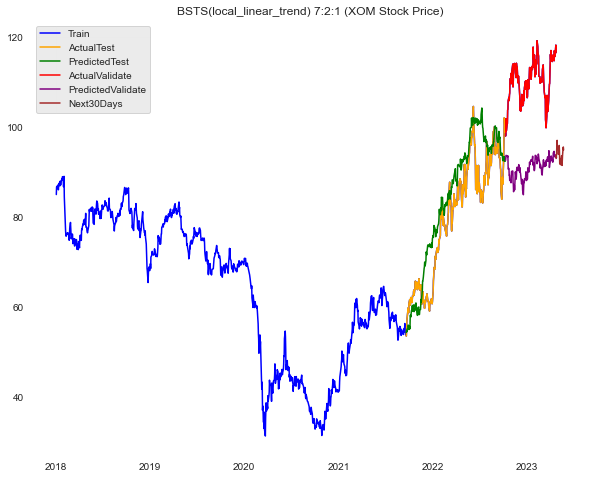

END====================================

DATA VLO
START====================================
Dataset size 1337 

Train size :  935
Test size :  267
Valid size :  135
forecast_samples size :  432
TestPred size :  267
ValidPred size :  135
Best sample ============================ 
Evaluate ----------------- 
Validation RMSE: 21.47778663185561
Testing RMSE: 32.18254285250196
Validation MAPE: 16.892485
Testing MAPE: 21.553967
Validation MDA: 54.47761194029851
Testing MDA: 53.75939849624061


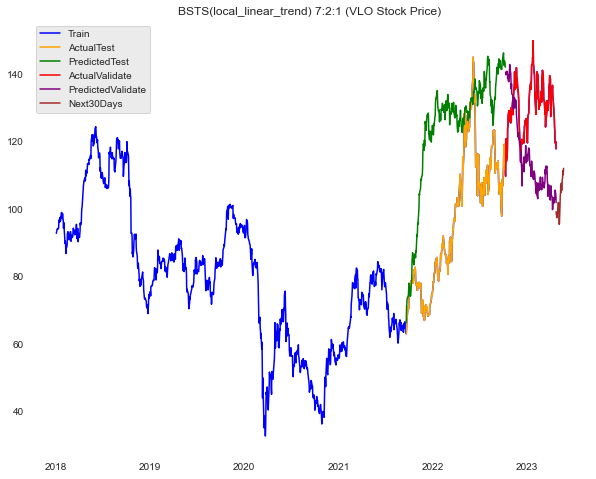

END====================================

DATA CVX
START====================================
Dataset size 1337 

Train size :  935
Test size :  267
Valid size :  135
forecast_samples size :  432
TestPred size :  267
ValidPred size :  135
Best sample ============================ 
Evaluate ----------------- 
Validation RMSE: 34.07776320876269
Testing RMSE: 17.108956722912254
Validation MAPE: 23.2031
Testing MAPE: 9.981523
Validation MDA: 44.02985074626866
Testing MDA: 51.8796992481203


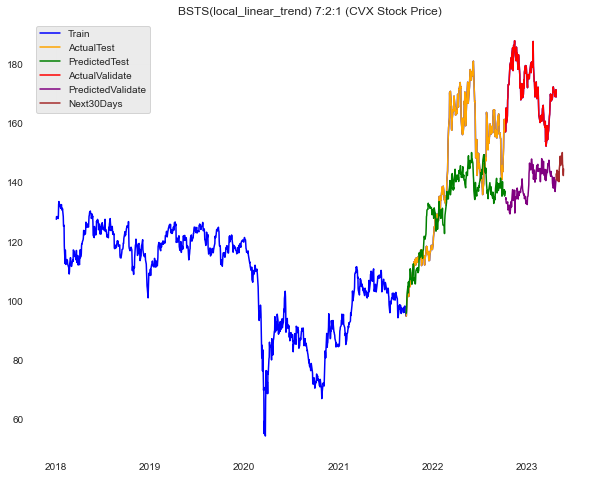

END====================================



In [33]:
data_set = ['XOM','VLO','CVX']
for data in data_set:
    
    print(f'DATA {data}')
    print('START====================================')
    data_path = os.path.join(DATA_FOLDER, f'{data}.csv')
    title = f'BSTS(local_linear_trend) 7:2:1 ({data} Stock Price)'
    model = BSTS(data_path)
    model.split_data(0.2,0.1)
    model.info_data()
    f_sample12=model.fit_surrogate_posterior(model.sum_model(['local_linear_trend']))
    best_sample = model.find_best_forecast_sample(f_sample12)
    # model.plot_mean_sample(f_sample12)
    print('Best sample ============================ ')
    model.plot_best_sample(best_sample,title)
    print('END===================================='+ '\n')

## Split size 6-2-2


DATA XOM
START====================================
Dataset size 1337 

Train size :  802
Test size :  267
Valid size :  268
forecast_samples size :  565
TestPred size :  267
ValidPred size :  268
Best sample ============================ 
Evaluate ----------------- 
Validation RMSE: 34.333099463200234
Testing RMSE: 20.08716509764771
Validation MAPE: 44.641624
Testing MAPE: 22.768726
Validation MDA: 50.187265917603
Testing MDA: 54.51127819548872


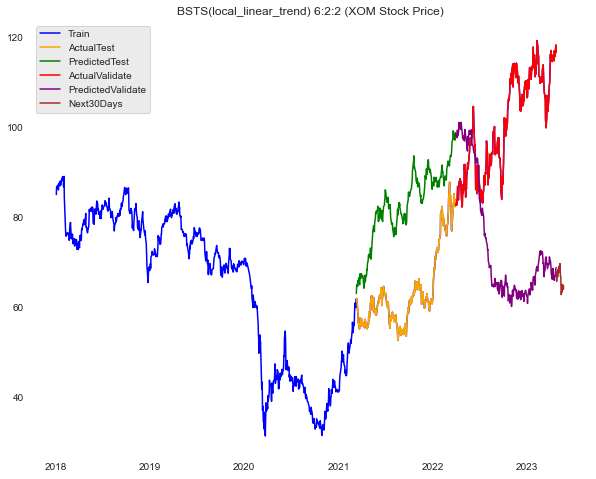

END====================================

DATA VLO
START====================================
Dataset size 1337 

Train size :  802
Test size :  267
Valid size :  268
forecast_samples size :  565
TestPred size :  267
ValidPred size :  268
Best sample ============================ 
Evaluate ----------------- 
Validation RMSE: 36.9354377596909
Testing RMSE: 31.296477156732433
Validation MAPE: 40.675316
Testing MAPE: 26.737549
Validation MDA: 52.80898876404494
Testing MDA: 56.015037593984964


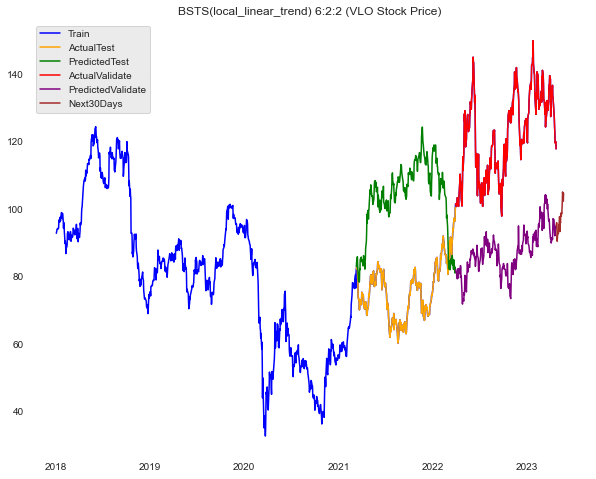

END====================================

DATA CVX
START====================================
Dataset size 1337 

Train size :  802
Test size :  267
Valid size :  268
forecast_samples size :  565
TestPred size :  267
ValidPred size :  268
Best sample ============================ 
Evaluate ----------------- 
Validation RMSE: 50.181900567149206
Testing RMSE: 28.703502438658838
Validation MAPE: 42.620583
Testing MAPE: 17.162481
Validation MDA: 54.68164794007491
Testing MDA: 47.744360902255636


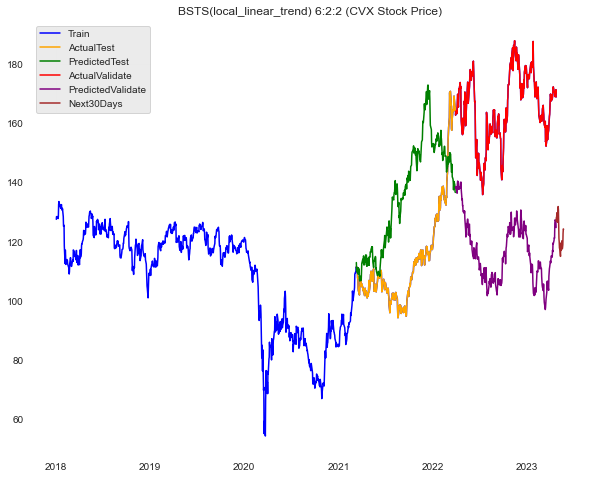

END====================================



In [34]:
data_set = ['XOM','VLO','CVX']
for data in data_set:
    
    print(f'DATA {data}')
    print('START====================================')
    data_path = os.path.join(DATA_FOLDER, f'{data}.csv')
    title = f'BSTS(local_linear_trend) 6:2:2 ({data} Stock Price)'
    model = BSTS(data_path)
    model.split_data(0.2,0.2)
    model.info_data()
    f_sample12=model.fit_surrogate_posterior(model.sum_model(['local_linear_trend']))
    best_sample = model.find_best_forecast_sample(f_sample12)
    # model.plot_mean_sample(f_sample12)
    print('Best sample ============================ ')
    model.plot_best_sample(best_sample,title)
    print('END===================================='+ '\n')